<br>
<br>
<h2>Purpose</h2>
<br>
<hr>
A notebook to develop an AI system aiming at trading intraday on cryptocurrencies
<br>
<br>

<br>
<br>
<h2>Imports</h2>
<br>
<hr>
<br>

In [4]:
# Pandas and Python
import pandas as pd
pd.options.display.float_format = '{:.4f}'.format
from warnings import simplefilter
simplefilter(action="ignore", category=pd.errors.PerformanceWarning)
import numpy as np
import os
import time

# Graphic Libraries
import plotly.io as pio
pio.templates.default = "simple_white"
pio.renderers.default = "notebook"
import matplotlib.pyplot as plt
from IPython.display import clear_output

# AI and stats
import statsmodels.api as sm
import lightgbm as lgb
from lightgbm import LGBMRegressor
import sklearn

# Multiprocessing
from functools import partial
from multiprocessing import Pool
from threadpoolctl import threadpool_limits



<br>
<br>
<h2>Notebook Parameters</h2>
<br>
<hr>
<br>

In [5]:
# Define data path
data_path = "in_sample/"

# Risk free rate assumption
risk_free_rate = 0.05 # % per year
rfr_hourly = (1 + risk_free_rate)**(1 / (24*365)) - 1

# Suggested training set
start_date_train = "2023-01-24"
last_date_train = "2024-01-24"

# Suggested validation set
start_date_validate = "2024-01-25"
last_date_validate = "2024-07-24"

# Test set (Unavailable)
# start_date_test = "2024-07-25"
# last_date_test = "2025-01-24"

# Maximum number of features to use
max_nb_features = 60

# Random seed for feature selection
random_seed = 0

# Set a level of transaction costs
tc = 0.0000

# Set the percentage of engineered features to use
pct_engineered_features = 0.25


<br>
<br>
<h2>Data Loading</h2>
<br>
<hr>
<br>

In [6]:
# Main data
data = pd.read_csv(
    f"{data_path}data_in_sample.csv",
    index_col=0,
    header=[0,1],
)

# Make sure that the index is in the right format
data.index = pd.to_datetime(data.index)


<h4>Features</h4>
Continue to use a simple first batch of features
<br>

In [7]:
simple_features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

# Iterate over some interesting fields to create features
for field in [
    "return",
    "close",
    "nb_trades",
    "volume_usd",
    "funding_rate",
    "open_interest_value"
]:
    print(f"Make features using raw field {field}")

    # Extract raw data
    raw_data = data[field]

    # Create raw feature
    for feature_style in [
        "level",
        "delta_1",
        "delta_6",
        "shift_1",
        "shift_3",
        "shift_6",
        "shift_24",
        "mean_6",
        "mean_24",
        "mean_120",
        "std_6",
        "std_24",
        "std_120",
        "skew_6",
        "skew_24",
        "skew_120",
        "kurt_6",
        "kurt_24",
        "kurt_120",
    ]:

        # Level
        if feature_style == "level":
            raw_feature = raw_data

        # Delta 1
        if feature_style == "delta_1":
            raw_feature = raw_data.pct_change(1, fill_method=None)

        # Delta 6
        if feature_style == "delta_6":
            raw_feature = raw_data.pct_change(6, fill_method=None)

        # Shift 1
        if feature_style == "shift_1":
            raw_feature = raw_data.shift(1)

        # Shift 3
        if feature_style == "shift_3":
            raw_feature = raw_data.shift(3)

        # Shift 6
        if feature_style == "shift_6":
            raw_feature = raw_data.shift(6)

        # Shift 24
        if feature_style == "shift_24":
            raw_feature = raw_data.shift(24)

        # Mean 6
        if feature_style == "mean_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,1).mean()

        # Mean 24
        if feature_style == "mean_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,1).mean()

        # Mean 120
        if feature_style == "mean_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,1).mean()

        # Std 6
        if feature_style == "std_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,2).std()

        # Std 24
        if feature_style == "std_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,2).std()

        # Std 120
        if feature_style == "std_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,2).std()

        # Skew 6
        if feature_style == "skew_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,3).skew()

        # Skew 24
        if feature_style == "skew_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,3).skew()

        # Skew 120
        if feature_style == "skew_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,3).skew()

        # Kurtosis 6
        if feature_style == "kurt_6":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(6,4).kurt()

        # Kurtosis 24
        if feature_style == "kurt_24":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(24,4).kurt()

        # Kurtosis 120
        if feature_style == "kurt_120":
            raw_feature = raw_data.dropna(axis=1, how="all").rolling(120,4).kurt()


        # Stack and store feature
        raw_feature = raw_feature.stack().reindex(simple_features.index)
        simple_features[f"{field}_{feature_style}"] = raw_feature



Make features using raw field return
Make features using raw field close
Make features using raw field nb_trades
Make features using raw field volume_usd
Make features using raw field funding_rate
Make features using raw field open_interest_value


<br>
Also use a certain percentage of engineered features
<br>
<br>

In [8]:
# Load engineered features
engineered_features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

for dirpath, dirnames, filenames in os.walk(data_path):

    # Only keep standard features for the moment
    filenames = [i for i in filenames if "feature" in i]

    # Select a random list of features (always the same)
    np.random.seed(random_seed)
    subset_filenames = np.random.choice(
        a=filenames,
        size=min(int(max_nb_features*pct_engineered_features), len(filenames)),
        replace=False,
    )
    for filename in subset_filenames:

        print(f"Loading {filename}")

        # Load feature
        feature = pd.read_csv(
            f"{data_path}{filename}",
            index_col=0,
            header=[0],
        )

        # Make sure that the index is in the right format
        feature.index = pd.to_datetime(feature.index)

        # Store in the feature dict
        engineered_features[filename.replace(".csv", "")] = feature.stack().reindex(
            engineered_features.index)


Loading feature_669028663444.csv
Loading feature_272923323412.csv
Loading feature_603841450314.csv
Loading feature_034613324449.csv
Loading feature_723195992091.csv
Loading feature_644984534227.csv
Loading feature_349700183501.csv
Loading feature_360363963222.csv
Loading feature_757966399344.csv
Loading feature_163039513711.csv
Loading feature_764560493700.csv
Loading feature_217884298030.csv
Loading feature_597112414582.csv
Loading feature_576016642244.csv
Loading feature_881677815989.csv


### Additional feature engineering

In [9]:
features = pd.DataFrame(
    np.nan,
    index=data["return"].stack().index,
    columns=[],
)

# Add your existing simple features
np.random.seed(random_seed)
subset_simple_features = np.random.choice(
    a=list(simple_features.keys()),
    size=min(int(max_nb_features*(1-pct_engineered_features)), len(simple_features.keys())),
    replace=False,
)

for feature_name in subset_simple_features:
    features[feature_name] = simple_features[feature_name]

# Add your existing engineered features
for feature_name in engineered_features:
    features[feature_name] = engineered_features[feature_name]

# ========= 1. REGIME FEATURES =========
print("1. Creating regime features...")

vol_24h = data["return"].rolling(24).std()
vol_threshold = vol_24h.rolling(24*7).quantile(0.7)
high_vol = (vol_24h > vol_threshold).astype(int)
features["regime_high_vol"] = high_vol.stack().reindex(features.index)

mom_24h = data["return"].rolling(24).sum()
mom_threshold = mom_24h.rolling(24*7).quantile(0.7)
trending = (mom_24h.abs() > mom_threshold.abs()).astype(int)
features["regime_trend"] = trending.stack().reindex(features.index)

print(f"   Added: 2 regime features")

# ========= 2. MARKET MICROSTRUCTURE =========
print("2. Creating microstructure features...")

spread_proxy = data["return"].rolling(6).std() / (data["volume_usd"].rolling(6).mean() + 1e-8)
features["spread_proxy_6h"] = spread_proxy.stack().reindex(features.index)

volume_momentum = data["volume_usd"].pct_change(6, fill_method=None)
features["volume_momentum_6h"] = volume_momentum.stack().reindex(features.index)

price_vol_corr = data["return"].rolling(24).corr(data["volume_usd"].pct_change(1, fill_method=None))
features["price_volume_corr_24h"] = price_vol_corr.stack().reindex(features.index)

trade_intensity = data["nb_trades"].rolling(6).sum() / (data["nb_trades"].rolling(24).sum() + 1e-8)
features["trade_intensity_ratio"] = trade_intensity.stack().reindex(features.index)

print(f"   Added: 4 microstructure features")

# ========= 3. CROSS-ASSET =========
print("3. Creating cross-asset features...")

market_avg_return = data["return"].mean(axis=1)
relative_return = data["return"].sub(market_avg_return, axis=0)
features["relative_return_1h"] = relative_return.stack().reindex(features.index)

asset_market_corr = data["return"].T.rolling(24).corr(data["return"].mean(axis=1)).T
features["market_corr_24h"] = asset_market_corr.stack().reindex(features.index)

return_rank = data["return"].rank(axis=1, pct=True)
features["return_rank_1h"] = return_rank.stack().reindex(features.index)

cross_vol = data["return"].std(axis=1)
features["cross_sectional_vol"] = cross_vol.reindex(features.index.get_level_values(0)).values

print(f"   Added: 4 cross-asset features")

# ========= 4. TIME-OF-DAY =========
print("4. Creating time-based features...")

n_assets = len(data["return"].columns)

hour = data.index.hour              # this is a numpy array / Index
hour_sin = np.sin(2 * np.pi * hour / 24)
hour_cos = np.cos(2 * np.pi * hour / 24)

features["hour_sin"] = pd.Series(
    np.repeat(hour_sin, n_assets),
    index=features.index,
)
features["hour_cos"] = pd.Series(
    np.repeat(hour_cos, n_assets),
    index=features.index,
)

day_of_week = data.index.dayofweek  # numpy array / Index again
dow_sin = np.sin(2 * np.pi * day_of_week / 7)
dow_cos = np.cos(2 * np.pi * day_of_week / 7)

features["dow_sin"] = pd.Series(
    np.repeat(dow_sin, n_assets),
    index=features.index,
)
features["dow_cos"] = pd.Series(
    np.repeat(dow_cos, n_assets),
    index=features.index,
)

is_weekend = (day_of_week >= 5).astype(int)
features["is_weekend"] = pd.Series(
    np.repeat(is_weekend, n_assets),
    index=features.index,
)

print(f"   Added: 5 time-based features")

# ========= 5. ADVANCED REGIMES =========
print("5. Creating advanced regime features...")

rolling_mean_24h = data["return"].rolling(24).mean()
distance_from_mean = (data["return"] - rolling_mean_24h) / (data["return"].rolling(24).std() + 1e-8)
features["mean_reversion_score"] = distance_from_mean.stack().reindex(features.index)

vol_low = (vol_24h < vol_24h.rolling(24*7).quantile(0.33)).astype(int)
vol_high = (vol_24h > vol_24h.rolling(24*7).quantile(0.67)).astype(int)
features["regime_vol_low"] = vol_low.stack().reindex(features.index)
features["regime_vol_high"] = vol_high.stack().reindex(features.index)

mom_strength = mom_24h.abs() / (data["return"].rolling(24).std() + 1e-8)
features["momentum_strength"] = mom_strength.stack().reindex(features.index)

up_streak = (data["return"] > 0).rolling(6).sum()
features["up_streak_6h"] = up_streak.stack().reindex(features.index)

print(f"   Added: 5 advanced regime features")

# ========= 6. FUNDING RATE DYNAMICS =========
print("6. Creating funding rate features...")

funding_delta_6h = data["funding_rate"].diff(6)
features["funding_delta_6h"] = funding_delta_6h.stack().reindex(features.index)

funding_zscore = (data["funding_rate"] - data["funding_rate"].rolling(24*7).mean()) / (data["funding_rate"].rolling(24*7).std() + 1e-8)
features["funding_zscore"] = funding_zscore.stack().reindex(features.index)

oi_change = data["open_interest_value"].pct_change(6, fill_method=None)
features["oi_change_6h"] = oi_change.stack().reindex(features.index)

print(f"   Added: 3 funding rate features")


1. Creating regime features...
   Added: 2 regime features
2. Creating microstructure features...
   Added: 4 microstructure features
3. Creating cross-asset features...
   Added: 4 cross-asset features
4. Creating time-based features...
   Added: 5 time-based features
5. Creating advanced regime features...
   Added: 5 advanced regime features
6. Creating funding rate features...
   Added: 3 funding rate features


<br>
Putting all features together
<br>
<br>

In [11]:
# NOTE: This cell is commented out to preserve the features created in the previous cell
# (which includes simple + engineered + 23 custom features).
# Feature selection will be done in the next cell to reach exactly 60 features.

# # Aggregate engineered and simple features all together
# features = pd.DataFrame(
#     np.nan,
#     index=data["return"].stack().index,
#     columns=[],
# )

# # Select a random list of simple features (always the same)
# np.random.seed(random_seed)
# subset_simple_features = np.random.choice(
#     a=list(simple_features.keys()),
#     size=min(int(max_nb_features*(1-pct_engineered_features)),
#              len(simple_features.keys())),
#     replace=False,
# )

# for feature_name in subset_simple_features:

#     features[feature_name] = simple_features[feature_name]

# for feature_name in engineered_features:

#     features[feature_name] = engineered_features[feature_name]

print(f"Features before selection: {len(features.columns)}")
print(f"Features shape: {features.shape}")

Features before selection: 83
Features shape: (5405472, 83)


Instead of doing random subset of features, we can choose feature more deliberately after consulting the top feature lists after running XGB model.

In [26]:
# Deliberate feature selection: top features + random fill to reach 60 total
# Best features identified from tuned LightGBM runs
top_features_base = [
    "regime_high_vol",
    "regime_vol_high",
    "regime_vol_low",
    "regime_trend",
    "relative_return_1h",
    "feature_881677815989",
    "return_shift_1",
    "feature_217884298030",
    "oi_change_6h",
    "mean_reversion_score",
    "feature_272923323412",
    "nb_trades_std_6",
    "feature_576016642244",
    "funding_rate_skew_24",
    "feature_360363963222",
    "volume_usd_delta_6",
    "feature_163039513711",
    "close_skew_24",
    "return_shift_24",
    "return_kurt_120",
    "funding_rate_shift_24",
    "nb_trades_std_120",
    "volume_usd_skew_24",
    "return_delta_6",
    "return_skew_6",
    "open_interest_value_kurt_120",
    "feature_034613324449",
    "open_interest_value_std_6",
    "volume_momentum_6h",
    "volume_usd_shift_1",
    "return_kurt_6",
    "feature_757966399344",
    "nb_trades_skew_6",
    "funding_rate_kurt_120",
    "volume_usd_shift_3",
    "volume_usd_kurt_6",
    "open_interest_value_std_24",
    "nb_trades_kurt_6",
    "feature_764560493700",
    "volume_usd_std_24",
    "volume_usd_shift_6",
    "funding_rate_skew_120",
    "volume_usd_mean_120",
    "open_interest_value_mean_6",
    "close_shift_6",
    "feature_597112414582",
    "open_interest_value_shift_1",
    "close_std_24",
    "open_interest_value_shift_3",
    "close_mean_6",
]

# Keep only those top features that exist in the current feature set
present_top = [f for f in top_features_base if f in features.columns]

# Target 60 features total
target_n = 60
n_random = max(0, target_n - len(present_top))

# Remaining features not in top list
remaining = [c for c in features.columns if c not in present_top]

# Randomly select additional features to reach 60 (using the same seed)
np.random.seed(random_seed)
random_extra = list(np.random.choice(
    remaining,
    size=min(n_random, len(remaining)),
    replace=False,
))

# Combine: top features first, then random extras
final_features = present_top + random_extra

print(f"Top features (present): {len(present_top)}")
print(f"Random extras: {len(random_extra)}")
print(f"Total in final_features: {len(final_features)}")

# Filter features to only include the selected ones
features = features[final_features].copy()
print(f"\nAfter deliberate selection: {features.shape}")

Top features (present): 50
Random extras: 10
Total in final_features: 60

After deliberate selection: (5405472, 60)


In [27]:
print(f"Total features: {len(features.columns)}")

Total features: 60


<br>
<br>
<h2>Analytics</h2>
<br>
<hr>
Basic Portfolio analytics to invest in some predictions of the future instruments returns
<br>
<br>


In [28]:
def expected_returns_to_positions(expected_returns):
    """
    Normalize expected returns to make it an investable portfolio

    :param expected_returns: pd.DataFrame containing expectations
                             about future instruments prices variations
    """

    # Positions will be proportional to ranked alpha
    positions = expected_returns.rank(axis=1)

    # Re-scale the leverage
    positions = positions.div(positions.abs().sum(axis=1), axis=0)

    # Make the portfolio dollar neutral
    positions = positions.sub(positions.mean(axis=1), axis=0)

    return positions


def get_sharpe(pnl_portfolio, rfr_hourly):
    """
    Compute the sharpe ratio

    :param pnl_portfolio: pd.Series of returns of the portfolio considered
    :param rfr_hourly: float, the hourly risk free rate
    """

    # Compute excess returns
    excess_returns = pnl_portfolio - rfr_hourly

    # Compute sharpe ratio
    sharpe_ratio = (
        excess_returns.mean() / excess_returns.std() * np.sqrt(24 * 365)
    )

    # Output
    return round(sharpe_ratio, 2)


def pnl_analytics(positions,
                  returns,
                  rfr_hourly,
                  lag,
                  tc=0):
    """
    Compute the p&l analytics of the strategy

    :param positions: pd.DataFrame, some positions that have been reached
    :param returns: pd.DataFrame containing returns of instruments
    :param rfr_hourly: float, the hourly risk free rate
    :param lag: int, the number of hours to reach the positions
    :param tc: float, the transaction costs

    """

    # Compute gross p&l
    pnl = positions.shift(1+lag).mul(returns).sum(axis=1)

    # Compute transaction costs
    trades = positions.fillna(0).diff()
    costs = trades.abs().sum(axis=1) * tc

    # Net p&l: deduce costs from gross p&l
    pnl = pnl.sub(costs, fill_value=0)

    # Compute sharpe
    sharpe = get_sharpe(pnl, rfr_hourly)

    return {"sharpe": sharpe,
           "pnl": pnl}


def analyze_expected_returns(
    expected_returns,
    returns,
    rfr_hourly,
    title = "a Nice Try",
    lags = [0,1,2,3,6,12],
    tc = 0,
    plot_option="matplotlib",
    output_stats=False,
):
    """
    Provide an economic analysis of some expected_returns

    :param expected_returns: pd.DataFrame containing expectations
                             about future instruments prices variations
    :param returns: pd.DataFrame containing returns of instruments
    :param rfr_hourly: float, the hourly risk free rate
    :param lags: list of int, corresponding to the number of hours to
                 reach the positions
    :param tc: float, the transaction costs
    :param plot_option: str, the library used to display the cumulative
                        p&l plot, can be "plotly" or "matplotlib"
    :param output_stats: boolean, wheter or not to output basic portfolio
                         statistics
    """

    # Take positions as a function of expected returns
    positions = expected_returns_to_positions(expected_returns)

    # Compute p&l and sharpe for different lags
    pnl_lags = {}
    for lag in lags:
        analytics_lag = pnl_analytics(
            positions=positions,
            returns=returns,
            rfr_hourly=rfr_hourly,
            lag=lag,
            tc=tc)
        lag_label = f"Lag {lag}, sharpe={analytics_lag['sharpe']}"
        pnl_lags[lag_label] = analytics_lag["pnl"]

    # Compute cumulative returns
    pnl_lags = pd.concat(pnl_lags, axis=1).dropna()
    cumulative_pnl_lags = (1+pnl_lags).cumprod().resample("24h").last()

    # Display
    if plot_option == "plotly":

        pd.options.plotting.backend = "plotly"

        fig = cumulative_pnl_lags.plot(
            title=f"Cumulative returns of {title}",
        )
        fig.update_layout(yaxis_type="log")
        fig.show()

    elif plot_option == "matplotlib":

        pd.options.plotting.backend = "matplotlib"

        ax = cumulative_pnl_lags.plot(
            title=f"Cumulative returns of {title}",
            logy=True,
            grid=False,
            figsize=(10, 4),
        )
        plt.show()

    else:
        raise ValueError("plot_option must be either 'plotly' or 'matplotlib'")

    # Output statistics if requested
    if output_stats:

        statistics = {}

        # Compute turnover
        turnover = positions.fillna(0).diff().abs().sum(axis=1).mean()
        statistics["turnover"] = round(turnover * 24, 2) # standardize the turnover to be daily

        # Compute sharpe
        statistics["sharpe"] = pnl_analytics(
            positions=positions,
            returns=returns,
            rfr_hourly=rfr_hourly,
            lag=lags[0],
            tc=tc,
        )["sharpe"]

        return pd.Series(statistics).to_frame("Statistics").T



<br>
<br>
<h2>Features Standard Pre-Processing</h2>
<br>
<hr>

<br>
We experimented with multi-horizon prediction


In [29]:
label = data["return"].loc[start_date_train:last_date_train
    ].shift(-1).stack()

In [30]:
# Define multiple prediction horizons (1h, 3h, 6h, 12h)
horizons = {
    "1h": 1,
    "3h": 3,
    "6h": 6,
    "12h": 12,
}

# Create labels for each horizon
labels_by_horizon = {}

for horizon_name, h in horizons.items():
    # Cumulative return over h hours
    label_horizon = data["return"].rolling(h).sum().shift(-h).stack()
    
    # Keep only dates in training range
    label_horizon = label_horizon.loc[start_date_train:last_date_train]
    
    labels_by_horizon[horizon_name] = label_horizon
    
    print(f"  - {horizon_name}: {len(label_horizon)} samples")

print("="*60)


  - 1h: 3600771 samples
  - 3h: 3600771 samples
  - 6h: 3600771 samples
  - 12h: 3600771 samples


In [31]:
features_normalized = pd.DataFrame().reindex_like(features)

for feature_name in features.keys():

    print(f"Pre-processing {feature_name}")

    # Extract the feature
    feature_normalized = features[feature_name].unstack()

    # Rank the feature to remove outliers
    feature_normalized = feature_normalized.rank(axis=1, pct=True) - 0.5

    # Stack the feature
    feature_normalized = feature_normalized.stack().reindex(
        features_normalized.index
    )

    # Store this normalized version
    features_normalized[feature_name] = feature_normalized

# Replace NaNs by average values, as OLS cannot handle NaNs effectively
features_normalized = features_normalized.fillna(0)

# Only keep datetimes that are common between the label and the features
# for training
common_index = label.index.intersection(features_normalized.index)
features_normalized_train = features_normalized.reindex(common_index)
label = label.reindex(common_index)


Pre-processing regime_high_vol
Pre-processing regime_vol_high
Pre-processing regime_vol_low
Pre-processing regime_trend
Pre-processing relative_return_1h
Pre-processing feature_881677815989
Pre-processing return_shift_1
Pre-processing feature_217884298030
Pre-processing oi_change_6h
Pre-processing mean_reversion_score
Pre-processing feature_272923323412
Pre-processing nb_trades_std_6
Pre-processing feature_576016642244
Pre-processing funding_rate_skew_24
Pre-processing feature_360363963222
Pre-processing volume_usd_delta_6
Pre-processing feature_163039513711
Pre-processing close_skew_24
Pre-processing return_shift_24
Pre-processing return_kurt_120
Pre-processing funding_rate_shift_24
Pre-processing nb_trades_std_120
Pre-processing volume_usd_skew_24
Pre-processing return_delta_6
Pre-processing return_skew_6
Pre-processing open_interest_value_kurt_120
Pre-processing feature_034613324449
Pre-processing open_interest_value_std_6
Pre-processing volume_momentum_6h
Pre-processing volume_usd_

<br>
<br>
<h2>LightGBM: Gradient Boosted Decision Trees</h2>
<br>
<hr>
LightGBM is a fast gradient boosting framework that introduces non-linearity in our model. This non-linearity is present in the link between the label and features, but also among the features themselves. Overfitting is limited thanks to a variety of strategies, resulting in potentially better generalization. LightGBM is faster and more memory-efficient than traditional methods.
<br>
<br>


<br>
<h4>Defining hyper-parameters</h4>
<br>



In [32]:
# Define hyperparameters
hyperparameters = {
    "learning_rate": 0.001,
    "n_estimators": 500,
    "objective": "regression",
    "max_depth": 7,
    "num_leaves": 31,
    "min_child_samples": 20,
    "subsample": 0.05,
    "subsample_freq": 1,
    "colsample_bytree": 0.3,
    "reg_lambda": 1.0,
    "reg_alpha": 0.0,
    "n_jobs": 1,
    "random_state": 0,
    "verbose": -1,
}

<br>
<h4>Training the models</h4>
<br>



We aaded booster to analyze feature importance boost, and use this to refine our feature engineering.

Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

Train a model from date 2022-09-05 00:00:00 to date 2023-08-31 00:00:00
Predict from date 2023-08-31 01:00:00 to date 2023-10-01 00:00:00

Train a model from date 2022-10-05 00:00:00 to date 2023-09-30 00:00:00
Predict from date 2023-09-30 01:00:00 to date 2023-10-31 00:00:00

Train a model from date 202

regime_high_vol                896.6875
regime_vol_high                773.0000
regime_vol_low                 666.3125
regime_trend                   661.6875
relative_return_1h             439.8750
feature_881677815989           417.0625
feature_217884298030           392.3125
oi_change_6h                   391.2500
return_shift_1                 385.1250
mean_reversion_score           345.3125
nb_trades_std_6                326.2500
feature_272923323412           315.7500
return_shift_24                314.5625
feature_360363963222           289.1250
feature_576016642244           283.7500
close_skew_24                  281.3750
return_kurt_120                278.3125
funding_rate_skew_24           274.5625
volume_usd_delta_6             271.3125
nb_trades_std_120              260.8125
open_interest_value_kurt_120   256.3125
feature_163039513711           256.1250
return_skew_6                  254.7500
funding_rate_shift_24          252.8750
volume_usd_skew_24             239.9375


Total Training time is 350.48411774635315 seconds


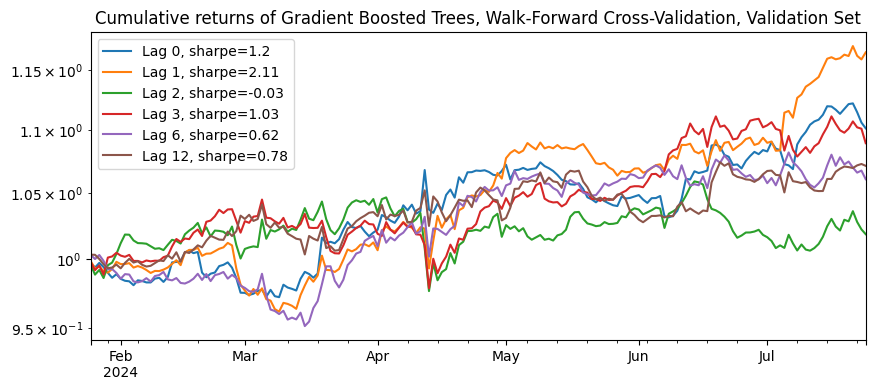

In [33]:
# Measure time
t1 = time.time()

# Recompute the model every month, skip the first 2 months
rebalancing_dates = pd.date_range(
    start=start_date_train,
    end=last_date_validate,
    freq="ME"
)[2:]

def train_predict_period(
    last_date_train_fold,
    returns,
    hyperparameters,
):

    # Force the usage of a single core inside of the function,
    # to avoid nested multiprocessing attempts
    with threadpool_limits(limits=1):

        # Define training and validation dates

        # Train the model over the last X months
        start_date_train_fold = last_date_train_fold - pd.Timedelta(days = 30 * 12)

        # The model cannot be used before the first hour following the training
        # (no look-forward bias)
        start_date_validate_fold = last_date_train_fold + pd.Timedelta(hours = 1)

        # The trained model will be used for 1 month
        last_date_validate_fold = last_date_train_fold + pd.Timedelta(days = 31 * 1)

        # Log informations
        print(f"Train a model from date {start_date_train_fold} to date {last_date_train_fold}")
        print(f"Predict from date {start_date_validate_fold} to date {last_date_validate_fold}")
        print("")


        # Create label
        label_fold = returns.loc[start_date_train_fold:last_date_train_fold
            ].shift(-1).stack()

        features_train_raw = features_normalized.reindex(label_fold.index)

        # mask: finite label AND all finite features
        mask = (
            np.isfinite(label_fold.values)
            & np.isfinite(features_train_raw).all(axis=1).values
        )

        label_fold = label_fold[mask] # mask to keep only rows with finite label and features
        features_normalized_train_fold = features_train_raw[mask]
        # Only keep dates of the train and validation sets for the features
        #features_normalized_train_fold = features_normalized.reindex(label_fold.index)
        features_normalized_validate_fold = features_normalized.sort_index().loc[
            start_date_validate_fold:last_date_validate_fold]

        # Split the data along the time axis
        ts_splitter = sklearn.model_selection.TimeSeriesSplit(n_splits=5)

        # Create model
        model = LGBMRegressor(**hyperparameters)

        # Fit model
        model = model.fit(
            y=label_fold,
            X=features_normalized_train_fold,
        )

        # Feature importance
        importance_gain = pd.Series(
            model.feature_importances_,
            index=features_normalized_train_fold.columns,
            name=str(last_date_train_fold)
        ).sort_values(ascending=False)

        # Predict on the validation set
        predictions = model.predict(
            features_normalized_validate_fold)
        predictions = pd.Series(
            predictions,
            index=features_normalized_validate_fold.index
        ).unstack()

        # Output results
        return (pd.concat({str(last_date_train_fold) : predictions}, axis=1), 
                importance_gain)
    

# Fix all but one function parameters to iterate on the last one
partial_train_predict_period = partial(
    train_predict_period,
    returns=data["return"],
    hyperparameters=hyperparameters,
)

# Train using one core per date
predictions = []
importances = [] # feature importance
for date in rebalancing_dates:
    pred, imp = train_predict_period(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters  # or model parameters
    )
    predictions.append(pred)
    importances.append(imp)

# Reformat predictions
predictions = pd.concat(predictions, axis=1).T.groupby(level=1).sum().T
importance_df = pd.concat(importances, axis=1).fillna(0)
importance_mean = importance_df.mean(axis=1).sort_values(ascending=False)

print("Top 50 features by average gain across folds:")
display(importance_mean.head(50))

# Remove extra zeros added in the process, as we don't want to take positions
# if there was no prediction
predictions = predictions.replace(0, np.nan)

# Remove empty and invalid dates
predictions = predictions.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"Total Training time is {t2-t1} seconds")

# Analyse our predictions
analyze_expected_returns(
    expected_returns=predictions.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"Gradient Boosted Trees, Walk-Forward Cross-Validation, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,

)

### Hyper parameter tuning

Start with a lightweight random search, if it outperforms the baseline, then we switch to Optuna with time series CV and early stopping for better efficiency 

In [34]:
# LightGBM Hyperparameter Tuning

from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

# Prepare training data
if "features_normalized" in globals():
    X_tune = features_normalized.copy()
else:
    # Fallback: compute normalized features on the fly
    X_tune = pd.DataFrame().reindex_like(features)
    for feature_name in features.keys():
        feature_normalized = features[feature_name].unstack()
        feature_normalized = feature_normalized.rank(axis=1, pct=True) - 0.5
        feature_normalized = feature_normalized.stack().reindex(X_tune.index)
        X_tune[feature_name] = feature_normalized
    X_tune = X_tune.fillna(0)

y_tune = label.copy()

# Align indices and sort
common_index = y_tune.index.intersection(X_tune.index)
X_tune = X_tune.reindex(common_index).sort_index()
y_tune = y_tune.reindex(common_index).reindex(X_tune.index)

# Remove non-finite labels and features
finite_mask = np.isfinite(y_tune.values) & np.isfinite(X_tune.values).all(axis=1)
X_tune = X_tune.loc[finite_mask]
y_tune = y_tune.loc[finite_mask]

# Time series split
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Random search space (LightGBM parameters)
param_space = {
    "max_depth": [4, 6, 8],
    "num_leaves": [15, 31, 63],
    "min_child_samples": [5, 10, 20],
    "subsample": [0.5, 0.8, 1.0],
    "colsample_bytree": [0.3, 0.6, 0.9],
    "learning_rate": [0.01, 0.05, 0.1],
    "n_estimators": [200, 400, 600],
}

n_trials = 12
rng = np.random.RandomState(random_seed)

# Build unique random parameter sets
param_list = []
seen = set()
while len(param_list) < n_trials:
    params = {k: rng.choice(v) for k, v in param_space.items()}
    key = tuple(sorted(params.items()))
    if key not in seen:
        seen.add(key)
        param_list.append(params)

results = []

for i, params in enumerate(param_list, 1):
    fold_mse = []

    # Merge with base hyperparameters
    trial_params = hyperparameters.copy()
    trial_params.update(params)

    for train_idx, val_idx in tscv.split(X_tune):
        X_train = X_tune.iloc[train_idx]
        y_train = y_tune.iloc[train_idx]
        X_val = X_tune.iloc[val_idx]
        y_val = y_tune.iloc[val_idx]

        model = LGBMRegressor(**trial_params)
        model.fit(X_train, y_train)

        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        fold_mse.append(mse)

    avg_mse = float(np.mean(fold_mse))
    results.append({"params": params, "mse": avg_mse})
    print(f"Trial {i}/{n_trials}: mse={avg_mse:.6f} | params={params}")

# Show best params
results = sorted(results, key=lambda x: x["mse"])
print("\nTop 5 parameter sets:")
for r in results[:5]:
    print(f"mse={r['mse']:.6f} | {r['params']}")

best_params = results[0]["params"]
print("\nBest params:")
print(best_params)

# Optional: create a tuned hyperparameters dict
hyperparameters_tuned = hyperparameters.copy()
hyperparameters_tuned.update(best_params)
print("\nTuned hyperparameters ready in `hyperparameters_tuned`.")


Trial 1/12: mse=0.000119 | params={'max_depth': np.int64(4), 'num_leaves': np.int64(31), 'min_child_samples': np.int64(5), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.6), 'learning_rate': np.float64(0.1), 'n_estimators': np.int64(200)}
Trial 2/12: mse=0.000119 | params={'max_depth': np.int64(8), 'num_leaves': np.int64(15), 'min_child_samples': np.int64(5), 'subsample': np.float64(0.5), 'colsample_bytree': np.float64(0.9), 'learning_rate': np.float64(0.05), 'n_estimators': np.int64(600)}
Trial 3/12: mse=0.000118 | params={'max_depth': np.int64(8), 'num_leaves': np.int64(15), 'min_child_samples': np.int64(10), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.6), 'learning_rate': np.float64(0.05), 'n_estimators': np.int64(200)}
Trial 4/12: mse=0.000117 | params={'max_depth': np.int64(6), 'num_leaves': np.int64(15), 'min_child_samples': np.int64(5), 'subsample': np.float64(0.8), 'colsample_bytree': np.float64(0.9), 'learning_rate': np.float64(0.01), 'n_esti


Tuned hyperparameters:
  learning_rate: 0.01
  n_estimators: 200
  max_depth: 4
  num_leaves: 15
  min_child_samples: 20
  subsample: 0.5
  colsample_bytree: 0.3

Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

Train a model from date 2022-09-05 00:00:00 to date 2023-08-31 00:00:00
Predict from date 2023-08-31 01:00:00 to date 2023-10-01 00:00:00

Tr

regime_high_vol             529.1875
regime_trend                409.6250
regime_vol_high             386.5625
regime_vol_low              378.6250
funding_rate_shift_24       207.3125
funding_rate_skew_24        129.1875
relative_return_1h           53.6875
funding_rate_std_6           49.8750
return_shift_1               29.5625
oi_change_6h                 29.3125
feature_217884298030         28.9375
mean_reversion_score         28.1250
feature_881677815989         27.8750
funding_rate_kurt_120        27.1875
nb_trades_std_6              26.5000
feature_272923323412         20.8750
volume_usd_delta_6           18.3750
funding_rate_kurt_24         18.3125
feature_360363963222         16.3125
return_shift_24              15.6875
volume_usd_shift_1           15.0625
feature_757966399344         14.5000
close_skew_24                14.0000
open_interest_value_std_6    13.9375
funding_rate_skew_120        13.9375
nb_trades_std_120            13.3125
volume_usd_skew_24           12.9375
r


Total Training time (Tuned LGBM): 259.9 seconds

TUNED LGBM RESULTS - VALIDATION SET


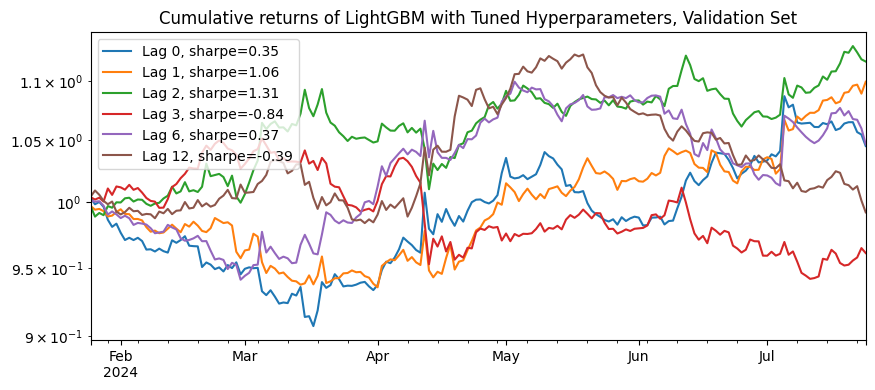

In [35]:
print("\nTuned hyperparameters:")
for k, v in hyperparameters_tuned.items():
    if k in ['max_depth', 'num_leaves', 'min_child_samples', 'subsample', 'colsample_bytree', 'learning_rate', 'n_estimators']:
        print(f"  {k}: {v}")
print("")

# Measure time
t1 = time.time()

# Train using one core per date with tuned hyperparameters
predictions_tuned = []
importances_tuned = []

for date in rebalancing_dates:
    pred, imp = train_predict_period(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters_tuned,
    )
    predictions_tuned.append(pred)
    importances_tuned.append(imp)

# Reformat predictions
predictions_tuned = pd.concat(predictions_tuned, axis=1).T.groupby(level=1).sum().T
importance_df_tuned = pd.concat(importances_tuned, axis=1).fillna(0)
importance_mean_tuned = importance_df_tuned.mean(axis=1).sort_values(ascending=False)

print("\nTop 30 features (Tuned LGBM) by average gain across folds:")
display(importance_mean_tuned.head(30))

# Remove extra zeros added in the process
predictions_tuned = predictions_tuned.replace(0, np.nan)

# Remove empty and invalid dates
predictions_tuned = predictions_tuned.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"\nTotal Training time (Tuned LGBM): {t2-t1:.1f} seconds")

# Analyse our predictions
print("\n" + "="*60)
print("TUNED LGBM RESULTS - VALIDATION SET")
print("="*60)
analyze_expected_returns(
    expected_returns=predictions_tuned.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"LightGBM with Tuned Hyperparameters, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,
)

Strong results at lag 3 and 6

## Experiment

#### Optuna Hyperparameter Tuning

Using Bayesian optimization with Optuna for more efficient search

In [36]:
import optuna
import sys
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

In [37]:
# Prepare data (reuse from earlier)
X_optuna = features_normalized.copy()
y_optuna = label.copy()

# Align indices
common_index = y_optuna.index.intersection(X_optuna.index)
X_optuna = X_optuna.reindex(common_index).sort_index()
y_optuna = y_optuna.reindex(common_index).reindex(X_optuna.index)

# Remove non-finite values
finite_mask = np.isfinite(y_optuna.values) & np.isfinite(X_optuna.values).all(axis=1)
X_optuna = X_optuna.loc[finite_mask]
y_optuna = y_optuna.loc[finite_mask]

print(f"Training data shape: {X_optuna.shape}")
print(f"Label shape: {y_optuna.shape}\n")

# Time series cross-validation
n_splits = 3
tscv = TimeSeriesSplit(n_splits=n_splits)

# Define the objective function for Optuna
def objective(trial):
    """
    Objective function for Optuna to minimize (mean MSE across CV folds)
    """
    # Suggest hyperparameters
    params = {
        "max_depth": trial.suggest_int("max_depth", 3, 10),
        "num_leaves": trial.suggest_int("num_leaves", 15, 127),
        "min_child_samples": trial.suggest_int("min_child_samples", 1, 50),
        "subsample": trial.suggest_float("subsample", 0.3, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.3, 1.0),
        "learning_rate": trial.suggest_float("learning_rate", 0.001, 0.1, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 800, step=100),
        "reg_alpha": trial.suggest_float("reg_alpha", 0, 10),
        "reg_lambda": trial.suggest_float("reg_lambda", 0, 10),
    }
    
    # Merge with base hyperparameters
    trial_params = hyperparameters.copy()
    trial_params.update(params)
    
    # Cross-validation
    fold_mse = []
    for train_idx, val_idx in tscv.split(X_optuna):
        X_train = X_optuna.iloc[train_idx]
        y_train = y_optuna.iloc[train_idx]
        X_val = X_optuna.iloc[val_idx]
        y_val = y_optuna.iloc[val_idx]
        
        model = LGBMRegressor(**trial_params)
        model.fit(X_train, y_train)
        
        preds = model.predict(X_val)
        mse = mean_squared_error(y_val, preds)
        fold_mse.append(mse)
    
    # Return mean MSE across folds
    return float(np.mean(fold_mse))

# Create Optuna study
print("Starting Optuna optimization...")
print(f"Using {n_splits}-fold TimeSeriesSplit\n")

study = optuna.create_study(
    direction="minimize",
    sampler=optuna.samplers.TPESampler(seed=random_seed),
    pruner=optuna.pruners.MedianPruner(),
)

# Run optimization (20 trials for good coverage)
study.optimize(
    objective,
    n_trials=20,
    show_progress_bar=True,
    n_jobs=1,  # Single job to avoid nested parallelism
)

# Display results
print("\n" + "="*60)
print("OPTUNA OPTIMIZATION RESULTS")
print("="*60)
print(f"\nBest MSE: {study.best_value:.6f}")
print(f"Number of trials: {len(study.trials)}")
print(f"\nBest hyperparameters:")
for key, value in study.best_params.items():
    print(f"  {key}: {value}")

# Create tuned hyperparameters dict
hyperparameters_optuna = hyperparameters.copy()
hyperparameters_optuna.update(study.best_params)

print("\nOptuna-tuned hyperparameters ready in `hyperparameters_optuna`.")

# Show optimization history
print("\nTop 5 trials:")
best_trials = sorted(study.trials, key=lambda t: t.value)[:5]
for i, trial in enumerate(best_trials, 1):
    print(f"\n{i}. Trial {trial.number}: MSE = {trial.value:.6f}")
    print(f"   Params: {trial.params}")

[I 2026-02-10 20:29:31,416] A new study created in memory with name: no-name-745545b9-f9e3-4c34-9cfc-8e7bae4ced8e


Training data shape: (1716459, 60)
Label shape: (1716459,)

Starting Optuna optimization...
Using 3-fold TimeSeriesSplit



Best trial: 0. Best value: 0.000116803:   5%|▌         | 1/20 [01:15<23:45, 75.01s/it]

[I 2026-02-10 20:30:46,424] Trial 0 finished with value: 0.00011680261536413835 and parameters: {'max_depth': 7, 'num_leaves': 95, 'min_child_samples': 31, 'subsample': 0.6814182280978278, 'colsample_bytree': 0.5965583595372332, 'learning_rate': 0.019578897201213006, 'n_estimators': 400, 'reg_alpha': 8.917730007820797, 'reg_lambda': 9.636627605010293}. Best is trial 0 with value: 0.00011680261536413835.


Best trial: 1. Best value: 0.000116388:  10%|█         | 2/20 [01:45<14:35, 48.65s/it]

[I 2026-02-10 20:31:16,625] Trial 1 finished with value: 0.00011638793200639201 and parameters: {'max_depth': 6, 'num_leaves': 104, 'min_child_samples': 27, 'subsample': 0.6976311927657526, 'colsample_bytree': 0.9479176468048627, 'learning_rate': 0.0013869861245357324, 'n_estimators': 100, 'reg_alpha': 0.2021839744032572, 'reg_lambda': 8.32619845547938}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  15%|█▌        | 3/20 [02:15<11:26, 40.40s/it]

[I 2026-02-10 20:31:47,206] Trial 2 finished with value: 0.00011686826915480635 and parameters: {'max_depth': 9, 'num_leaves': 113, 'min_child_samples': 49, 'subsample': 0.8594109949517064, 'colsample_bytree': 0.6230355535770522, 'learning_rate': 0.03639639356786391, 'n_estimators': 100, 'reg_alpha': 6.399210213275238, 'reg_lambda': 1.433532874090464}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  20%|██        | 4/20 [04:21<19:44, 74.01s/it]

[I 2026-02-10 20:33:52,733] Trial 3 finished with value: 0.00011800333329134876 and parameters: {'max_depth': 10, 'num_leaves': 73, 'min_child_samples': 21, 'subsample': 0.48518892847323886, 'colsample_bytree': 0.8419635826039515, 'learning_rate': 0.008171478915115866, 'n_estimators': 500, 'reg_alpha': 0.18789800436355142, 'reg_lambda': 6.176354970758771}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  25%|██▌       | 5/20 [06:26<23:06, 92.46s/it]

[I 2026-02-10 20:35:57,915] Trial 4 finished with value: 0.00011742719003104026 and parameters: {'max_depth': 7, 'num_leaves': 84, 'min_child_samples': 48, 'subsample': 0.7772742093724383, 'colsample_bytree': 0.5516555304016502, 'learning_rate': 0.007482796037620797, 'n_estimators': 600, 'reg_alpha': 0.6022547162926983, 'reg_lambda': 6.667667154456677}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  30%|███       | 6/20 [07:34<19:38, 84.20s/it]

[I 2026-02-10 20:37:06,092] Trial 5 finished with value: 0.00011657148814742941 and parameters: {'max_depth': 8, 'num_leaves': 38, 'min_child_samples': 7, 'subsample': 0.5207998456469287, 'colsample_bytree': 0.5545975396598358, 'learning_rate': 0.01381635682257479, 'n_estimators': 400, 'reg_alpha': 9.883738380592263, 'reg_lambda': 1.0204481074802807}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  35%|███▌      | 7/20 [08:10<14:46, 68.23s/it]

[I 2026-02-10 20:37:41,420] Trial 6 finished with value: 0.0001164143543312209 and parameters: {'max_depth': 4, 'num_leaves': 33, 'min_child_samples': 33, 'subsample': 0.4773041217778474, 'colsample_bytree': 0.6264175409994144, 'learning_rate': 0.003082131641442948, 'n_estimators': 200, 'reg_alpha': 1.1037514116430513, 'reg_lambda': 6.563295894652734}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  40%|████      | 8/20 [08:28<10:29, 52.44s/it]

[I 2026-02-10 20:38:00,075] Trial 7 finished with value: 0.0001165942646962971 and parameters: {'max_depth': 4, 'num_leaves': 37, 'min_child_samples': 19, 'subsample': 0.8746952608935545, 'colsample_bytree': 0.36797089305514286, 'learning_rate': 0.04741216804249709, 'n_estimators': 100, 'reg_alpha': 9.764594650133958, 'reg_lambda': 4.686512016477016}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  45%|████▌     | 9/20 [09:32<10:17, 56.12s/it]

[I 2026-02-10 20:39:04,276] Trial 8 finished with value: 0.00011643531684782682 and parameters: {'max_depth': 10, 'num_leaves': 83, 'min_child_samples': 37, 'subsample': 0.3274314545780245, 'colsample_bytree': 0.4979648738034867, 'learning_rate': 0.0017393745944806983, 'n_estimators': 300, 'reg_alpha': 1.1872771895424405, 'reg_lambda': 3.1798317939397602}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  50%|█████     | 10/20 [09:54<07:34, 45.47s/it]

[I 2026-02-10 20:39:25,907] Trial 9 finished with value: 0.00011642338543318233 and parameters: {'max_depth': 6, 'num_leaves': 22, 'min_child_samples': 35, 'subsample': 0.6966210179446026, 'colsample_bytree': 0.48577264365761175, 'learning_rate': 0.01113002415673064, 'n_estimators': 100, 'reg_alpha': 5.759464955561793, 'reg_lambda': 9.292961975762141}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  55%|█████▌    | 11/20 [12:46<12:38, 84.27s/it]

[I 2026-02-10 20:42:18,139] Trial 10 finished with value: 0.00011644735534680228 and parameters: {'max_depth': 5, 'num_leaves': 126, 'min_child_samples': 2, 'subsample': 0.9507482485194814, 'colsample_bytree': 0.9779912742714763, 'learning_rate': 0.001037208617473408, 'n_estimators': 700, 'reg_alpha': 2.8680202851300667, 'reg_lambda': 7.997334657688051}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  60%|██████    | 12/20 [13:17<09:03, 67.98s/it]

[I 2026-02-10 20:42:48,880] Trial 11 finished with value: 0.00011640639551723966 and parameters: {'max_depth': 3, 'num_leaves': 55, 'min_child_samples': 27, 'subsample': 0.5338957855303754, 'colsample_bytree': 0.7656760872427106, 'learning_rate': 0.0027314376813180196, 'n_estimators': 200, 'reg_alpha': 3.109073535417676, 'reg_lambda': 7.297574676384754}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  65%|██████▌   | 13/20 [14:00<07:03, 60.51s/it]

[I 2026-02-10 20:43:32,200] Trial 12 finished with value: 0.00011642832974302217 and parameters: {'max_depth': 3, 'num_leaves': 53, 'min_child_samples': 17, 'subsample': 0.5817548052920335, 'colsample_bytree': 0.7924395779985651, 'learning_rate': 0.0033569956896683916, 'n_estimators': 300, 'reg_alpha': 3.629267254825729, 'reg_lambda': 8.219498864558778}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  70%|███████   | 14/20 [14:30<05:06, 51.07s/it]

[I 2026-02-10 20:44:01,450] Trial 13 finished with value: 0.00011640532143452611 and parameters: {'max_depth': 3, 'num_leaves': 64, 'min_child_samples': 26, 'subsample': 0.3472739295952314, 'colsample_bytree': 0.7856837137609038, 'learning_rate': 0.003278371614485886, 'n_estimators': 200, 'reg_alpha': 2.9800051154519323, 'reg_lambda': 7.895774994640221}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  75%|███████▌  | 15/20 [16:42<06:18, 75.73s/it]

[I 2026-02-10 20:46:14,330] Trial 14 finished with value: 0.00011641191203498289 and parameters: {'max_depth': 5, 'num_leaves': 102, 'min_child_samples': 12, 'subsample': 0.31102054831459996, 'colsample_bytree': 0.998629430133595, 'learning_rate': 0.001047209208541999, 'n_estimators': 800, 'reg_alpha': 2.212211896971317, 'reg_lambda': 5.186295906490033}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  80%|████████  | 16/20 [17:26<04:24, 66.10s/it]

[I 2026-02-10 20:46:58,062] Trial 15 finished with value: 0.00011640881225307945 and parameters: {'max_depth': 6, 'num_leaves': 62, 'min_child_samples': 41, 'subsample': 0.40451183990523365, 'colsample_bytree': 0.8624304468751178, 'learning_rate': 0.004849938895263396, 'n_estimators': 200, 'reg_alpha': 4.631712003351634, 'reg_lambda': 8.772540008465613}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  85%|████████▌ | 17/20 [18:21<03:07, 62.67s/it]

[I 2026-02-10 20:47:52,745] Trial 16 finished with value: 0.00011639533798559913 and parameters: {'max_depth': 5, 'num_leaves': 125, 'min_child_samples': 25, 'subsample': 0.622358384012341, 'colsample_bytree': 0.7179154445950853, 'learning_rate': 0.0018458047114021912, 'n_estimators': 300, 'reg_alpha': 1.8838625874559136, 'reg_lambda': 4.026029926140828}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  90%|█████████ | 18/20 [19:22<02:04, 62.26s/it]

[I 2026-02-10 20:48:54,058] Trial 17 finished with value: 0.00011639645825689841 and parameters: {'max_depth': 5, 'num_leaves': 127, 'min_child_samples': 14, 'subsample': 0.6057605435648202, 'colsample_bytree': 0.9139215471699746, 'learning_rate': 0.001556560891753302, 'n_estimators': 300, 'reg_alpha': 1.8158564284178862, 'reg_lambda': 3.1863594906106774}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388:  95%|█████████▌| 19/20 [21:30<01:21, 81.81s/it]

[I 2026-02-10 20:51:01,416] Trial 18 finished with value: 0.00011651730538444491 and parameters: {'max_depth': 8, 'num_leaves': 114, 'min_child_samples': 23, 'subsample': 0.7701839035048044, 'colsample_bytree': 0.7078414206822596, 'learning_rate': 0.0018130312666621278, 'n_estimators': 500, 'reg_alpha': 4.51159614295175, 'reg_lambda': 3.022921129600406}. Best is trial 1 with value: 0.00011638793200639201.


Best trial: 1. Best value: 0.000116388: 100%|██████████| 20/20 [22:32<00:00, 67.63s/it]

[I 2026-02-10 20:52:03,996] Trial 19 finished with value: 0.00011647697245148426 and parameters: {'max_depth': 6, 'num_leaves': 109, 'min_child_samples': 43, 'subsample': 0.750905066224417, 'colsample_bytree': 0.6958747176244562, 'learning_rate': 0.005729712582894681, 'n_estimators': 300, 'reg_alpha': 7.167308458432984, 'reg_lambda': 4.698367017421809}. Best is trial 1 with value: 0.00011638793200639201.

OPTUNA OPTIMIZATION RESULTS

Best MSE: 0.000116
Number of trials: 20

Best hyperparameters:
  max_depth: 6
  num_leaves: 104
  min_child_samples: 27
  subsample: 0.6976311927657526
  colsample_bytree: 0.9479176468048627
  learning_rate: 0.0013869861245357324
  n_estimators: 100
  reg_alpha: 0.2021839744032572
  reg_lambda: 8.32619845547938

Optuna-tuned hyperparameters ready in `hyperparameters_optuna`.

Top 5 trials:

1. Trial 1: MSE = 0.000116
   Params: {'max_depth': 6, 'num_leaves': 104, 'min_child_samples': 27, 'subsample': 0.6976311927657526, 'colsample_bytree': 0.94791764680486

TRAINING LIGHTGBM WITH OPTUNA-TUNED HYPERPARAMETERS

Optuna-tuned hyperparameters:
  learning_rate: 0.0013869861245357324
  n_estimators: 100
  max_depth: 6
  num_leaves: 104
  min_child_samples: 27
  subsample: 0.6976311927657526
  colsample_bytree: 0.9479176468048627
  reg_lambda: 8.32619845547938
  reg_alpha: 0.2021839744032572

Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00



Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

Train a model from date 2022-09-05 00:00:00 to date 2023-08-31 00:00:00
Predict from date 2023-08-31 01:00:00 to date 2023-10-01 00:00:00

Train a model from date 2022-10-05 00:00:00 to date 2023-09-30 00:00:00
Predict from date 2023-09-30 01:00:00 to date 2023-10-31 00:00:00

Train a model from date 2022-11-05 00:00:00 to date 2023-10-31 00:00:00
Predict from date 2023-10-31 01:00:00 to date 2023-12-01 00:00:00

Train a model from date 202

regime_high_vol                1461.6250
regime_vol_low                 1360.5000
regime_trend                   1172.1250
regime_vol_high                1068.7500
funding_rate_shift_24           402.6250
funding_rate_skew_24             56.4375
nb_trades_std_6                  16.9375
relative_return_1h               13.6250
return_shift_1                   12.6250
funding_rate_std_6               10.8750
feature_217884298030             10.6875
oi_change_6h                      9.7500
open_interest_value_std_6         8.7500
feature_881677815989              8.5000
mean_reversion_score              8.1875
close_skew_24                     7.4375
feature_034613324449              7.1250
volume_usd_shift_3                7.0625
nb_trades_std_120                 6.8750
feature_764560493700              6.8125
return_kurt_6                     6.7500
feature_360363963222              6.6875
volume_usd_shift_1                6.6250
return_kurt_120                   6.2500
return_shift_24 


Total Training time (Optuna-Tuned LGBM): 236.8 seconds

OPTUNA-TUNED LGBM RESULTS - VALIDATION SET


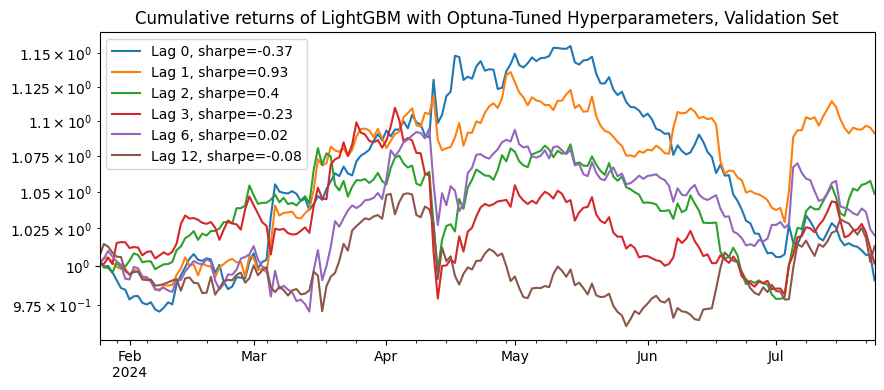

In [38]:
# LightGBM WITH OPTUNA-TUNED HYPERPARAMETERS

print("="*60)
print("TRAINING LIGHTGBM WITH OPTUNA-TUNED HYPERPARAMETERS")
print("="*60)
print("\nOptuna-tuned hyperparameters:")
for k, v in hyperparameters_optuna.items():
    if k in ['max_depth', 'num_leaves', 'min_child_samples', 'subsample', 'colsample_bytree', 
             'learning_rate', 'n_estimators', 'reg_alpha', 'reg_lambda']:
        print(f"  {k}: {v}")
print("")

# Measure time
t1 = time.time()

# Train using one core per date with Optuna-tuned hyperparameters
predictions_optuna = []
importances_optuna = []

for date in rebalancing_dates:
    pred, imp = train_predict_period(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters_optuna,
    )
    predictions_optuna.append(pred)
    importances_optuna.append(imp)

# Reformat predictions
predictions_optuna = pd.concat(predictions_optuna, axis=1).T.groupby(level=1).sum().T
importance_df_optuna = pd.concat(importances_optuna, axis=1).fillna(0)
importance_mean_optuna = importance_df_optuna.mean(axis=1).sort_values(ascending=False)

print("\nTop 30 features (Optuna-Tuned LGBM) by average gain across folds:")
display(importance_mean_optuna.head(30))

# Remove extra zeros added in the process
predictions_optuna = predictions_optuna.replace(0, np.nan)

# Remove empty and invalid dates
predictions_optuna = predictions_optuna.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"\nTotal Training time (Optuna-Tuned LGBM): {t2-t1:.1f} seconds")

# Analyse our predictions
print("\n" + "="*60)
print("OPTUNA-TUNED LGBM RESULTS - VALIDATION SET")
print("="*60)
analyze_expected_returns(
    expected_returns=predictions_optuna.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"LightGBM with Optuna-Tuned Hyperparameters, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,
)

#### Time decay weights 

The training uses 12 moneths of history with equal weights, I make the model care more about recent patterns by giving time decay sample weights, so we compute weight for each timestamp in each training fold, and pass these weights to model fit

In [39]:
def train_predict_period_timedecay(
    last_date_train_fold,
    returns,
    hyperparameters,
    lambda_decay=0.05,
):
    """
    Train LightGBM with time-decayed sample weights.
    Recent data has higher weight than older data.

    :param last_date_train_fold: last training date for this fold
    :param returns: return data
    :param hyperparameters: LGBM hyperparameters dict
    :param lambda_decay: decay rate for time weights (0.01-0.1 typical)
    """

    # Force the usage of a single core inside of the function,
    # to avoid nested multiprocessing attempts
    with threadpool_limits(limits=1):

        # Define training and validation dates
        start_date_train_fold = last_date_train_fold - pd.Timedelta(days=30*12)
        start_date_validate_fold = last_date_train_fold + pd.Timedelta(hours=1)
        last_date_validate_fold = last_date_train_fold + pd.Timedelta(days=31)

        # Log informations
        print(f"Train a model from date {start_date_train_fold} to date {last_date_train_fold}")
        print(f"Predict from date {start_date_validate_fold} to date {last_date_validate_fold}")
        print("")

        # Create label
        label_fold = returns.loc[start_date_train_fold:last_date_train_fold].shift(-1).stack()

        features_train_raw = features_normalized.reindex(label_fold.index)

        # mask: finite label AND all finite features
        mask = (
            np.isfinite(label_fold.values)
            & np.isfinite(features_train_raw).all(axis=1).values
        )

        label_fold = label_fold[mask]
        features_normalized_train_fold = features_train_raw[mask]
        features_normalized_validate_fold = features_normalized.sort_index().loc[
            start_date_validate_fold:last_date_validate_fold]

        # ===== TIME-DECAYED SAMPLE WEIGHTS =====
        # Recent data matters more than older data
        dates_train = label_fold.index.get_level_values(0)
        age = (last_date_train_fold - dates_train)
        age_days = age / np.timedelta64(1, "D")

        sample_weights = np.exp(-lambda_decay * age_days)
        sample_weights = np.asarray(sample_weights, dtype=float)

        print(
            f"   Time-decay (lambda={lambda_decay}): weights in "
            f"[{sample_weights.min():.4f}, {sample_weights.max():.4f}], "
            f"mean={sample_weights.mean():.4f}"
        )

        # Create model
        model = LGBMRegressor(**hyperparameters)

        # Fit model with sample weights
        model = model.fit(
            y=label_fold,
            X=features_normalized_train_fold,
            sample_weight=sample_weights,
        )

        # Feature importance (LightGBM style)
        importance_gain = pd.Series(
            model.feature_importances_,
            index=features_normalized_train_fold.columns,
            name=str(last_date_train_fold)
        ).sort_values(ascending=False)

        # Predict on the validation set
        predictions = model.predict(features_normalized_validate_fold)
        predictions = pd.Series(
            predictions,
            index=features_normalized_validate_fold.index
        ).unstack()

        # Output results
        return (pd.concat({str(last_date_train_fold) : predictions}, axis=1),
                importance_gain)


Train a model from date 2022-04-05 00:00:00 to date 2023-03-31 00:00:00
Predict from date 2023-03-31 01:00:00 to date 2023-05-01 00:00:00

   Time-decay (lambda=0.05): weights in [0.0369, 0.9979], mean=0.3007
Train a model from date 2022-05-05 00:00:00 to date 2023-04-30 00:00:00
Predict from date 2023-04-30 01:00:00 to date 2023-05-31 00:00:00

   Time-decay (lambda=0.05): weights in [0.0082, 0.9979], mean=0.2166
Train a model from date 2022-06-05 00:00:00 to date 2023-05-31 00:00:00
Predict from date 2023-05-31 01:00:00 to date 2023-07-01 00:00:00

   Time-decay (lambda=0.05): weights in [0.0017, 0.9979], mean=0.1679
Train a model from date 2022-07-05 00:00:00 to date 2023-06-30 00:00:00
Predict from date 2023-06-30 01:00:00 to date 2023-07-31 00:00:00

   Time-decay (lambda=0.05): weights in [0.0004, 0.9979], mean=0.1360
Train a model from date 2022-08-05 00:00:00 to date 2023-07-31 00:00:00
Predict from date 2023-07-31 01:00:00 to date 2023-08-31 00:00:00

   Time-decay (lambda=0.0

regime_high_vol                914.3750
regime_vol_high                797.4375
regime_trend                   716.3750
regime_vol_low                 705.8125
relative_return_1h             431.7500
feature_881677815989           397.1875
feature_217884298030           394.8125
return_shift_1                 385.8750
oi_change_6h                   374.3750
mean_reversion_score           329.5625
return_shift_24                329.5000
funding_rate_skew_24           328.0000
funding_rate_shift_24          317.4375
feature_272923323412           317.3125
nb_trades_std_6                309.4375
feature_576016642244           286.5000
feature_360363963222           285.8750
close_skew_24                  271.9375
return_kurt_120                271.2500
feature_163039513711           270.2500
volume_usd_delta_6             264.1875
open_interest_value_kurt_120   254.6250
return_skew_6                  254.0625
return_delta_6                 237.6250
nb_trades_std_120              235.8125



Total Training time (Time-Decay): 391.9 seconds

TIME-DECAY LGBM RESULTS


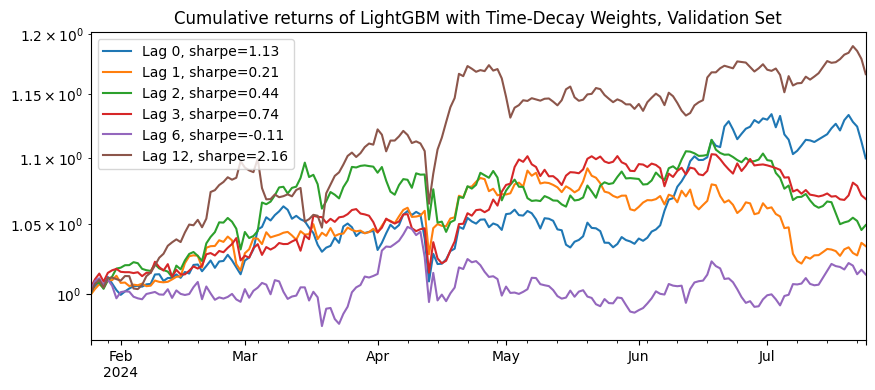

In [40]:
# LightGBM WITH TIME-DECAYED WEIGHTS

# Measure time
t1 = time.time()

# Lambda for time decay (higher = faster decay)
lambda_decay = 0.05

# Train using one core per date, with time-decay weights
predictions_timedecay = []
importances_timedecay = []

for date in rebalancing_dates:
    pred, imp = train_predict_period_timedecay(
        last_date_train_fold=date,
        returns=data['return'],
        hyperparameters=hyperparameters,
        lambda_decay=lambda_decay,
    )
    predictions_timedecay.append(pred)
    importances_timedecay.append(imp)

# Reformat predictions
predictions_timedecay = pd.concat(predictions_timedecay, axis=1).T.groupby(level=1).sum().T
importance_df_timedecay = pd.concat(importances_timedecay, axis=1).fillna(0)
importance_mean_timedecay = importance_df_timedecay.mean(axis=1).sort_values(ascending=False)

print("\nTop 50 features (Time-Decay XGB) by average gain across folds:")
display(importance_mean_timedecay.head(50))

# Remove extra zeros added in the process
predictions_timedecay = predictions_timedecay.replace(0, np.nan)

# Remove empty and invalid dates
predictions_timedecay = predictions_timedecay.dropna(axis=0, how='all')

# Training finished, print time used for it
t2 = time.time()
print(f"\nTotal Training time (Time-Decay): {t2-t1:.1f} seconds")

# Analyse our predictions
print("\n" + "="*60)
print("TIME-DECAY LGBM RESULTS")
print("="*60)
analyze_expected_returns(
    expected_returns=predictions_timedecay.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title=f"LightGBM with Time-Decay Weights, Validation Set",
    lags=[0,1,2,3,6,12],
    tc=tc,
)


Lag 12 P&L is noticeable. This model with time decay seems to suit longer-lag trading but not competitive at lag 0-1

#### LGBM for multi-horizon


TRAINING LIGHTGBM FOR HORIZON: 1H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-3

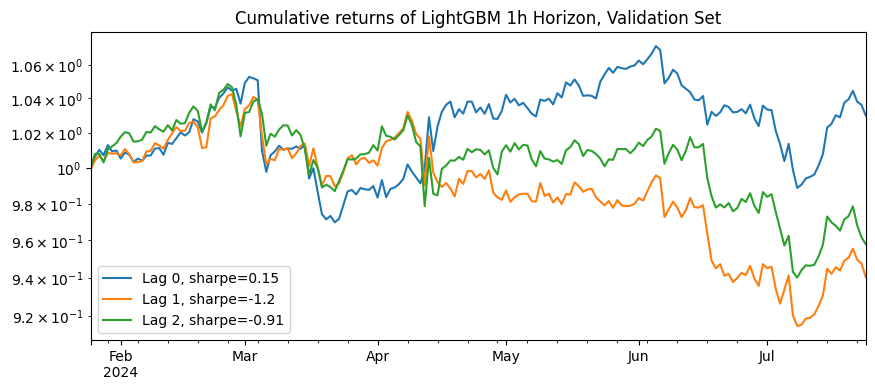


TRAINING LIGHTGBM FOR HORIZON: 3H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-3

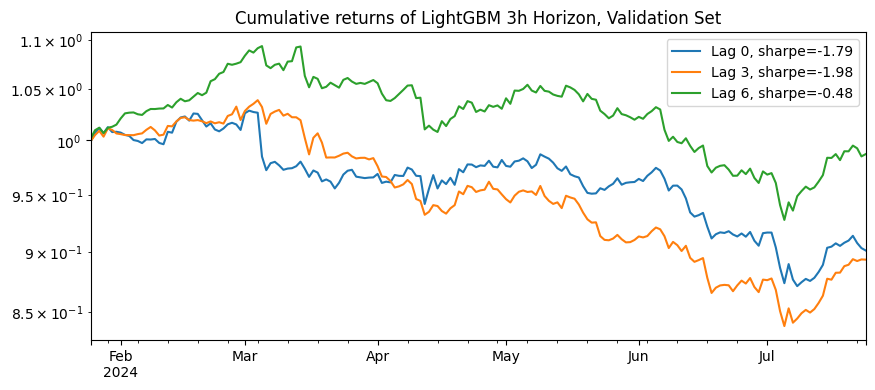


TRAINING LIGHTGBM FOR HORIZON: 6H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-3

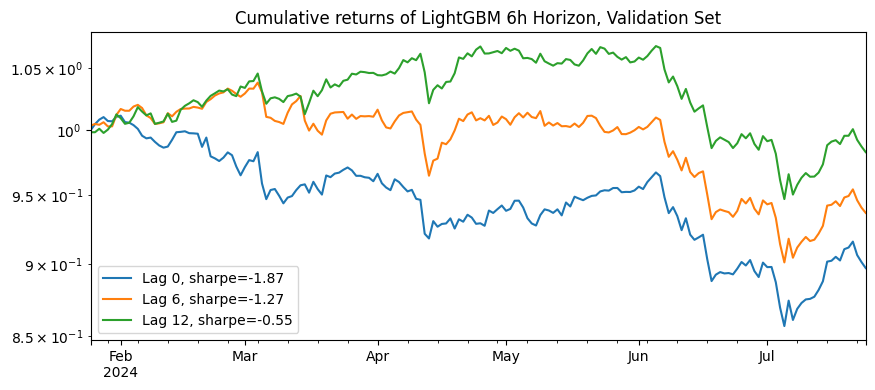


TRAINING LIGHTGBM FOR HORIZON: 12H

Train from 2022-04-05 00:00:00 to 2023-03-31 00:00:00
Predict from 2023-03-31 01:00:00 to 2023-05-01 00:00:00

Train from 2022-05-05 00:00:00 to 2023-04-30 00:00:00
Predict from 2023-04-30 01:00:00 to 2023-05-31 00:00:00

Train from 2022-06-05 00:00:00 to 2023-05-31 00:00:00
Predict from 2023-05-31 01:00:00 to 2023-07-01 00:00:00

Train from 2022-07-05 00:00:00 to 2023-06-30 00:00:00
Predict from 2023-06-30 01:00:00 to 2023-07-31 00:00:00

Train from 2022-08-05 00:00:00 to 2023-07-31 00:00:00
Predict from 2023-07-31 01:00:00 to 2023-08-31 00:00:00

Train from 2022-09-05 00:00:00 to 2023-08-31 00:00:00
Predict from 2023-08-31 01:00:00 to 2023-10-01 00:00:00

Train from 2022-10-05 00:00:00 to 2023-09-30 00:00:00
Predict from 2023-09-30 01:00:00 to 2023-10-31 00:00:00

Train from 2022-11-05 00:00:00 to 2023-10-31 00:00:00
Predict from 2023-10-31 01:00:00 to 2023-12-01 00:00:00

Train from 2022-12-05 00:00:00 to 2023-11-30 00:00:00
Predict from 2023-11-

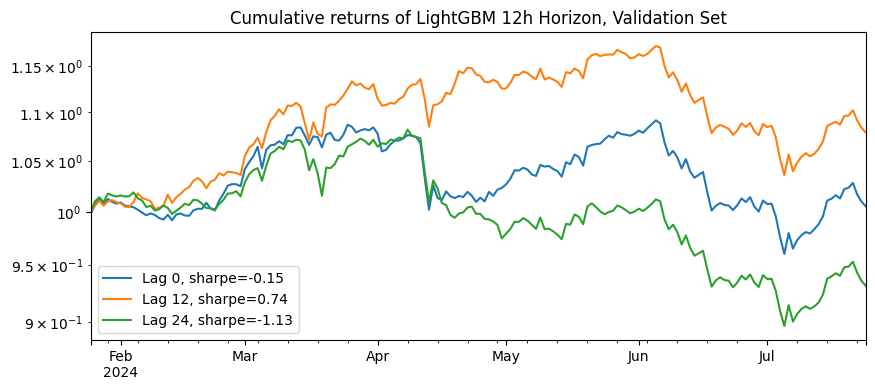

In [42]:
# Hyperparameters (keep th existing ones)
# Rebalancing dates
rebalancing_dates = pd.date_range(
    start=start_date_train,
    end=last_date_validate,
    freq="ME",
)[2:]

# Store predictions for each horizon
predictions_by_horizon = {}

# ===== LOOP OVER HORIZONS =====
for horizon_name, h in horizons.items():
    
    print(f"\n{'='*60}")
    print(f"TRAINING LIGHTGBM FOR HORIZON: {horizon_name.upper()}")
    print(f"{'='*60}\n")
    
    # Get label for this horizon
    label = labels_by_horizon[horizon_name]
    
    # Only keep common datetimes between label and features
    common_index = label.index.intersection(features_normalized.index)
    featuresnormalized_train = features_normalized.reindex(common_index)
    label_train = label.reindex(common_index)
    
    # Training loop (walk-forward cross-validation)
    t1 = time.time()
    
    predictions_list = []
    
    for date in rebalancing_dates:
        
        # Define fold dates
        start_date_train_fold = date - pd.Timedelta(days=30*12)
        start_date_validate_fold = date + pd.Timedelta(hours=1)
        last_date_validate_fold = date + pd.Timedelta(days=31)
        
        print(f"Train from {start_date_train_fold} to {date}")
        print(f"Predict from {start_date_validate_fold} to {last_date_validate_fold}\n")
        
        # Create label for this fold
        label_fold = label_train.loc[start_date_train_fold:date]
        
        # Features for train and validation
        features_train_fold = featuresnormalized_train.reindex(label_fold.index)
        features_validate_fold = features_normalized.loc[
            start_date_validate_fold:last_date_validate_fold
        ]
        
        # ===== TIME-DECAYED SAMPLE WEIGHTS =====
        # Recent data matters more than older data
        dates_train = label_fold.index.get_level_values(0)
        age = (date - dates_train)
        age_days = age / np.timedelta64(1, "D")
        
        lambda_decay = 0.05  # adjust: higher => faster decay
        sample_weights = np.exp(-lambda_decay * age_days)
        
        # ===== FILTER NON-FINITE VALUES =====
        # Remove NaN/inf from labels and features
        mask = (
            np.isfinite(label_fold.values)
            & np.isfinite(features_train_fold).all(axis=1).values
        )
        label_fold = label_fold[mask]
        features_train_fold = features_train_fold[mask]
        sample_weights = np.asarray(sample_weights[mask], dtype=np.float32)
        
        # Train LightGBM
        with threadpool_limits(limits=1):
            model = LGBMRegressor(**hyperparameters)
            model.fit(
                X=features_train_fold,
                y=label_fold,
                sample_weight=sample_weights,
            )
            
            # Predict
            pred = model.predict(features_validate_fold)
            pred = pd.Series(pred, index=features_validate_fold.index).unstack()
            
            predictions_list.append(
                pd.concat({str(date): pred}, axis=1)
            )
    
    # Reformat predictions
    predictions = pd.concat(predictions_list, axis=1).T.groupby(level=1).sum().T
    predictions = predictions.replace(0, np.nan).dropna(axis=0, how='all')
    
    t2 = time.time()
    print(f"\nTotal training time for {horizon_name}: {t2-t1:.1f} seconds")
    
    # Store predictions
    predictions_by_horizon[horizon_name] = predictions
    
    # Analyze this horizon
    print(f"\n{'='*60}")
    print(f"RESULTS FOR HORIZON: {horizon_name.upper()}")
    print(f"{'='*60}")
    
    analyze_expected_returns(
        expected_returns=predictions.loc[start_date_validate:last_date_validate],
        returns=data["return"].loc[start_date_validate:last_date_validate],
        rfr_hourly=rfr_hourly,
        title=f"LightGBM {horizon_name} Horizon, Validation Set",
        lags=[0, h, h*2],
        tc=tc,
    )

Then we ensemble across horizons

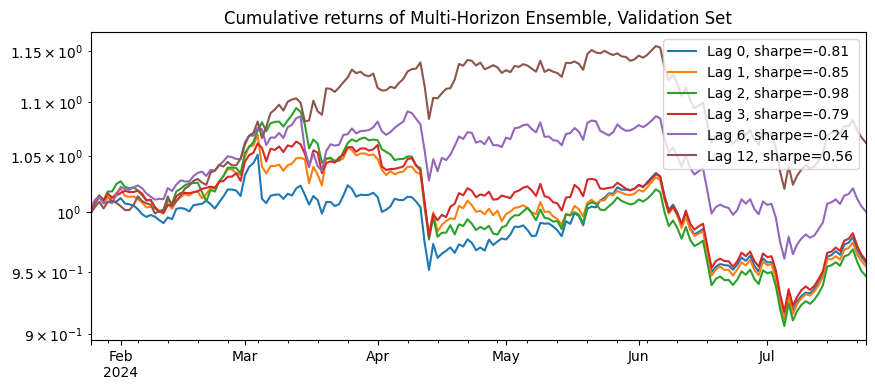

In [43]:
# Simple averaging ensemble
predictions_ensemble = (
    predictions_by_horizon["1h"] +
    predictions_by_horizon["3h"] +
    predictions_by_horizon["6h"] +
    predictions_by_horizon["12h"]
) / 4

# Analyze ensemble
analyze_expected_returns(
    expected_returns=predictions_ensemble.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title="Multi-Horizon Ensemble, Validation Set",
    lags=[0, 1, 2, 3, 6, 12],
    tc=tc,
)


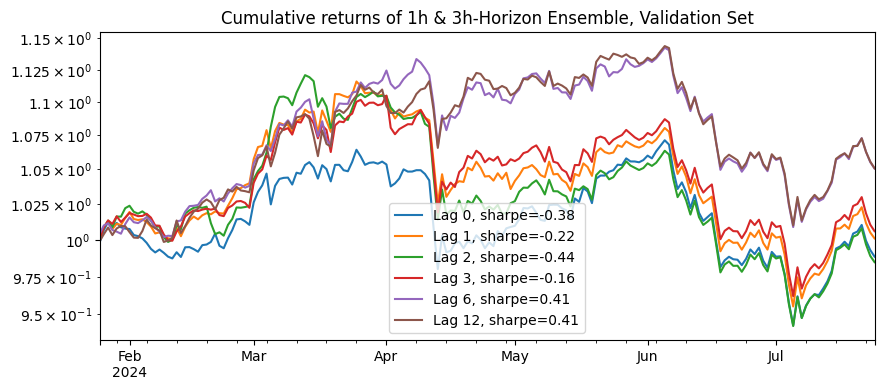

In [44]:
# veraging ensemble between 1h and 3h horizons, which are more similar and have better performance than the 6h and 12h horizons
predictions_ensemble = (
    predictions_by_horizon["6h"] +
    predictions_by_horizon["12h"] 
) / 2

# Analyze ensemble
analyze_expected_returns(
    expected_returns=predictions_ensemble.loc[start_date_validate:last_date_validate],
    returns=data["return"].loc[start_date_validate:last_date_validate],
    rfr_hourly=rfr_hourly,
    title="1h & 3h-Horizon Ensemble, Validation Set",
    lags=[0, 1, 2, 3, 6, 12],
    tc=tc,
)